##### Import the libraries

In [1]:
import os
import json
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from torchvision.ops import box_iou
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import precision_recall_fscore_support
import rich
import shutil
from sklearn.model_selection import train_test_split
from ultralytics import YOLO

##### split the dataset & create annotation bsed on yolo requirements

In [2]:
# Paths for input data
image_dir = os.path.join("ZJU_dataset_2", "images")
annotation_dir = os.path.join("ZJU_dataset_2", "annotation")

# Paths for YOLO-formatted dataset
output_dir = "datasets"
train_images_dir = os.path.join(output_dir, "train", "images")
train_labels_dir = os.path.join(output_dir, "train", "labels")
val_images_dir = os.path.join(output_dir, "val", "images")
val_labels_dir = os.path.join(output_dir, "val", "labels")

# Create output directories
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(val_labels_dir, exist_ok=True)

# Function to convert annotations to YOLO format
def convert_to_yolo_format(annotation_path, image_width, image_height):
    with open(annotation_path) as f:
        data = json.load(f)

    yolo_annotations = []
    for shape in data["shapes"]:
        if shape["label"] == "window":  # Filter for "window" objects
            points = shape["points"]
            x_coords = [p[0] for p in points]
            y_coords = [p[1] for p in points]
            x_min = min(x_coords)
            y_min = min(y_coords)
            x_max = max(x_coords)
            y_max = max(y_coords)

            # Convert to YOLO format [class_id, center_x, center_y, width, height]
            center_x = ((x_min + x_max) / 2) / image_width
            center_y = ((y_min + y_max) / 2) / image_height
            width = (x_max - x_min) / image_width
            height = (y_max - y_min) / image_height

            yolo_annotations.append(f"0 {center_x} {center_y} {width} {height}")

    return yolo_annotations

# Load all image filenames and split into train/val sets
image_filenames = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
train_files, val_files = train_test_split(image_filenames, test_size=0.2, random_state=42)

# Process and save train and val data
for dataset, image_files, images_dir, labels_dir in [
    ("train", train_files, train_images_dir, train_labels_dir),
    ("val", val_files, val_images_dir, val_labels_dir)
]:
    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)
        annotation_path = os.path.join(annotation_dir, f"{os.path.splitext(img_file)[0]}.json")

        # Copy image to output directory
        shutil.copy(img_path, images_dir)

        # Open image to get dimensions
        with Image.open(img_path) as img:
            width, height = img.size

        # Convert annotations to YOLO format and save
        yolo_annotations = convert_to_yolo_format(annotation_path, width, height)
        label_path = os.path.join(labels_dir, f"{os.path.splitext(img_file)[0]}.txt")
        with open(label_path, "w") as label_file:
            label_file.write("\n".join(yolo_annotations))

print(f"Dataset organized successfully!")
print(f"Train images: {len(train_files)}, Validation images: {len(val_files)}")

Dataset organized successfully!
Train images: 200, Validation images: 50


##### checking the input data

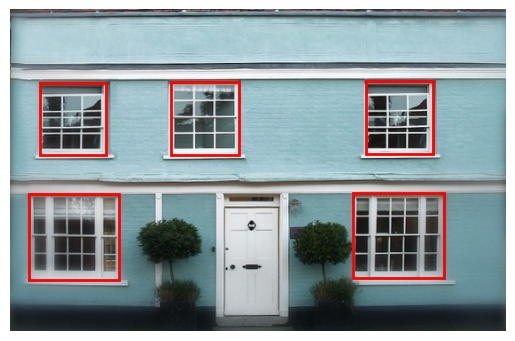

In [3]:
def visualize_annotations_by_index(dataset_path, index):
    # Construct paths for images and labels
    images_path = os.path.join(dataset_path, "images")
    labels_path = os.path.join(dataset_path, "labels")

    # Get sorted list of image and label files
    image_files = sorted(os.listdir(images_path))
    label_files = sorted(os.listdir(labels_path))

    # Ensure the index is valid
    if index < 0 or index >= len(image_files):
        raise ValueError(f"Invalid index: {index}. Must be between 0 and {len(image_files) - 1}.")

    # Get the image and label file for the given index
    image_file = os.path.join(images_path, image_files[index])
    label_file = os.path.join(labels_path, label_files[index])

    # Load the image
    img = Image.open(image_file)
    img_width, img_height = img.size

    # Load annotations
    with open(label_file, 'r') as f:
        lines = f.readlines()

    # Create a figure and axis
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    for line in lines:
        parts = line.strip().split()
        cls, x_center, y_center, width, height = map(float, parts)

        # Convert normalized coordinates to pixel values
        x_center *= img_width
        y_center *= img_height
        width *= img_width
        height *= img_height

        # Calculate box corners
        x_min = x_center - width / 2
        y_min = y_center - height / 2

        # Create a rectangle patch
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='red', facecolor='none')

        # Add the rectangle to the plot
        ax.add_patch(rect)

    plt.axis('off')  # Hide axes for better visualization
    plt.show()

# Example usage
dataset_path = "datasets/train"
index = 3  # 0-based index
visualize_annotations_by_index(dataset_path, index)

##### Define The Model

In [4]:
# Load a pretrained YOLO model (e.g., YOLOv8n for a lightweight version)
model = YOLO('yolov8n.pt')  # Replace with yolov8s.pt, yolov8m.pt, etc., as needed

##### Hyper parameters tuning 

In [ ]:
import random
from ultralytics import YOLO

def find_best_hyperparameters(data_path, project_name, num_trials=10):
    """
    Function to find the best hyperparameters for YOLO model training.
    
    Parameters:
        data_path (str): Path to the data.yaml file.
        project_name (str): Name of the project folder for saving results.
        num_trials (int): Number of random trials for hyperparameter search.
        
    Returns:
        dict: Best hyperparameters and their corresponding validation results.
    """
    best_hyperparams = None
    best_score = float('-inf')

    # Define hyperparameter ranges
    hyperparameter_space = {
        "epochs": [5, 10, 20],
        "batch_size": [8, 16, 32],
        "learning_rate": [1e-4, 1e-3, 1e-2],
        "momentum": [0.8, 0.9, 0.95],
        "weight_decay": [1e-5, 1e-4, 1e-3]
    }

    for trial in range(num_trials):
        # Randomly sample hyperparameters
        epochs = random.choice(hyperparameter_space["epochs"])
        batch_size = random.choice(hyperparameter_space["batch_size"])
        learning_rate = random.choice(hyperparameter_space["learning_rate"])
        momentum = random.choice(hyperparameter_space["momentum"])
        weight_decay = random.choice(hyperparameter_space["weight_decay"])

        print(f"Trial {trial + 1}/{num_trials}: Testing with hyperparameters:")
        print(f"  Epochs: {epochs}, Batch Size: {batch_size}, Learning Rate: {learning_rate}")
        print(f"  Momentum: {momentum}, Weight Decay: {weight_decay}")

        # Create and train the model
        model = YOLO("yolov8n.pt")  # Replace with appropriate YOLO model
        model.train(
            data=data_path,
            epochs=epochs,
            batch=batch_size,
            lr0=learning_rate,
            momentum=momentum,
            weight_decay=weight_decay,
            project=project_name,
            name=f"trial_{trial + 1}"
        )

        # Validate the model
        results = model.val(data=data_path)
        mAP_50 = results.box.map50  # Mean Average Precision at IoU 0.5

        print(f"  Validation mAP@0.5: {mAP_50}")

        # Update best hyperparameters if the current trial is better
        if mAP_50 > best_score:
            best_score = mAP_50
            best_hyperparams = {
                "epochs": epochs,
                "batch_size": batch_size,
                "learning_rate": learning_rate,
                "momentum": momentum,
                "weight_decay": weight_decay,
                "map_50": mAP_50
            }

    print("Best Hyperparameters Found:")
    print(best_hyperparams)
    return best_hyperparams

In [ ]:
data_path = "yolo_data.yaml"
project_name = "FacadeDetection"

best_hyperparams = find_best_hyperparameters(data_path, project_name, num_trials=10)

print("Optimal Hyperparameters:")
print(best_hyperparams)

##### Train the model

In [5]:
# https://docs.ultralytics.com/modes/train/?utm_source=chatgpt.com#train-settings
# Train the model
model.train(
    data="yolo_data.yaml",         # Path to data.yaml or dict specifying train/val paths
    epochs=50,                # Number of epochs
    batch=16,            # Batch size
    project="FacadeDetection", # Project folder for saving results
    name="YOLOv8_training",    # Experiment name
    pretrained=True,           # Use pretrained weights
    patience = 3,
    optimizer = "SGD",
    cos_lr = True,
    momentum = 0.9,
    weight_decay = 0.0005,
    lr0 = 0.005,
    device = "cuda:0",
    imgsz = 256,
    plots = True
)

New https://pypi.org/project/ultralytics/8.3.69 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.58  Python-3.10.0 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 6144MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=yolo_data.yaml, epochs=50, time=None, patience=3, batch=16, imgsz=256, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=FacadeDetection, name=YOLOv8_training22, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, s

train: Scanning C:\Users\mohamad\WWR\datasets\train\labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]
val: Scanning C:\Users\mohamad\WWR\datasets\val\labels.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]


Plotting labels to FacadeDetection\YOLOv8_training22\labels.jpg... 
optimizer: SGD(lr=0.005, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 256 train, 256 val
Using 8 dataloader workers
Logging results to FacadeDetection\YOLOv8_training22
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      1.18G      2.168      3.484       1.31        212        256: 100%|██████████| 13/13 [00:02<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]

                   all         50        659     0.0329      0.748     0.0325     0.0142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.16G      1.684      2.829      1.125        157        256: 100%|██████████| 13/13 [00:01<00:00,  9.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.14it/s]

                   all         50        659     0.0391      0.891       0.15     0.0746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.17G      1.564      1.902      1.068        226        256: 100%|██████████| 13/13 [00:01<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.26it/s]

                   all         50        659       0.74      0.469      0.651      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      1.16G      1.497      1.244      1.023        184        256: 100%|██████████| 13/13 [00:01<00:00, 10.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.53it/s]

                   all         50        659      0.733       0.75      0.773      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.17G      1.448      1.122     0.9971        156        256: 100%|██████████| 13/13 [00:01<00:00, 10.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.57it/s]

                   all         50        659      0.765      0.744      0.787      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      1.17G      1.399      1.072     0.9935        163        256: 100%|██████████| 13/13 [00:01<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.50it/s]

                   all         50        659      0.819      0.715      0.815      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      1.17G      1.454      1.021     0.9915        175        256: 100%|██████████| 13/13 [00:01<00:00, 11.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.20it/s]

                   all         50        659      0.829      0.726      0.824       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.17G      1.465      0.978      0.985        190        256: 100%|██████████| 13/13 [00:01<00:00, 10.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]

                   all         50        659      0.828      0.771       0.84      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      1.16G      1.422     0.9921     0.9863        130        256: 100%|██████████| 13/13 [00:01<00:00, 11.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]

                   all         50        659      0.802      0.769      0.844      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.17G      1.327      0.949     0.9706        131        256: 100%|██████████| 13/13 [00:01<00:00,  9.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.58it/s]

                   all         50        659      0.826      0.803      0.854      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.17G       1.34     0.9259     0.9571        168        256: 100%|██████████| 13/13 [00:01<00:00,  9.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.81it/s]

                   all         50        659      0.816      0.815      0.865      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.17G       1.32     0.9012     0.9627        173        256: 100%|██████████| 13/13 [00:01<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.54it/s]

                   all         50        659      0.827      0.848      0.883      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      1.16G      1.324     0.8892     0.9617        184        256: 100%|██████████| 13/13 [00:01<00:00, 10.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.27it/s]

                   all         50        659      0.852      0.855      0.887      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.17G      1.336     0.8634      0.957        203        256: 100%|██████████| 13/13 [00:01<00:00,  8.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.92it/s]


                   all         50        659      0.872      0.827      0.886      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.17G      1.273     0.8846     0.9509        207        256: 100%|██████████| 13/13 [00:01<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.06it/s]

                   all         50        659      0.865      0.835      0.886      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.17G      1.274     0.8628     0.9529        166        256: 100%|██████████| 13/13 [00:01<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.63it/s]

                   all         50        659      0.874       0.83      0.896      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      1.17G      1.294     0.8637     0.9537        177        256: 100%|██████████| 13/13 [00:01<00:00, 10.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]

                   all         50        659      0.861      0.833      0.891      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      1.17G      1.229     0.8258     0.9331        234        256: 100%|██████████| 13/13 [00:01<00:00, 11.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.79it/s]

                   all         50        659      0.848       0.81      0.861      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.17G      1.242     0.8067     0.9461        124        256: 100%|██████████| 13/13 [00:01<00:00, 10.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.91it/s]

                   all         50        659      0.848      0.847      0.878      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.17G      1.269     0.8136     0.9312        225        256: 100%|██████████| 13/13 [00:01<00:00, 10.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.55it/s]

                   all         50        659       0.84      0.855      0.879      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.16G      1.228     0.8248     0.9186        208        256: 100%|██████████| 13/13 [00:01<00:00, 10.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.40it/s]

                   all         50        659      0.833      0.854      0.876      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.17G      1.238     0.8007     0.9303        256        256: 100%|██████████| 13/13 [00:01<00:00,  9.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.66it/s]

                   all         50        659      0.847      0.849      0.877       0.55
EarlyStopping: Training stopped early as no improvement observed in last 3 epochs. Best results observed at epoch 19, best model saved as best.pt.
To update EarlyStopping(patience=3) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



22 epochs completed in 0.014 hours.
Optimizer stripped from FacadeDetection\YOLOv8_training22\weights\last.pt, 6.2MB
Optimizer stripped from FacadeDetection\YOLOv8_training22\weights\best.pt, 6.2MB

Validating FacadeDetection\YOLOv8_training22\weights\best.pt...
Ultralytics 8.3.58  Python-3.10.0 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 6144MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.89it/s]


                   all         50        659      0.847      0.845      0.877      0.559
Speed: 0.3ms preprocess, 5.4ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to FacadeDetection\YOLOv8_training22


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000020E594F2800>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

##### load the trained weights

In [6]:
# Load the custom-trained weights
model = YOLO('FacadeDetection/YOLOv8_training22/weights/best.pt')

##### validate the model

In [7]:
results = model.val(
    data="yolo_data.yaml",         # Path to data.yaml or dict specifying train/val paths
    epochs=50,                # Number of epochs
    batch=16,            # Batch size
    project="FacadeDetection", # Project folder for saving results
    name="YOLOv8_training_val",    # Experiment name
    plots = True,
    iou = 0.5,     # Sets the Intersection Over Union (IoU) threshold for Non-Maximum Suppression (NMS).
    device = "cuda:0"
)
print(results)

Ultralytics 8.3.58  Python-3.10.0 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 6144MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning C:\Users\mohamad\WWR\datasets\val\labels.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.44s/it]


                   all         50        659      0.867      0.847      0.874      0.547
Speed: 0.7ms preprocess, 18.7ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to FacadeDetection\YOLOv8_training_val2
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000020E36E96A40>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031

In [8]:
# Extract and display the IoU metric
mean_iou = results.box.map50  # mAP50 (mean Average Precision at IoU threshold 0.5)
print(f"Mean IoU: {mean_iou}")

Mean IoU: 0.8736317106432271


##### some checks to verify the results

In [9]:
# image_path = os.path.join("datasets", "train", "images", "00001.jpg")
image_path = os.path.join("Evaluation_subset", "rectified_facade_DENW11AL0000h3Gt.jpg")

# Run prediction
results = model.predict(source=image_path, conf=0.5, save=False, save_txt=False, show=False)

# Check results
for result in results:
    print("Number of detections:", len(result.boxes))
    print("Bounding boxes:", result.boxes.xyxy)  # Bounding box coordinates
    print("Confidence scores:", result.boxes.conf)  # Confidence scores
    print("Classes:", result.boxes.cls)  # Detected classes


image 1/1 c:\Users\mohamad\WWR\Evaluation_subset\rectified_facade_DENW11AL0000h3Gt.jpg: 224x256 6 windows, 55.0ms
Speed: 1.1ms preprocess, 55.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 256)
Number of detections: 6
Bounding boxes: tensor([[167.1798,  24.1003, 196.7793,  81.8505],
        [237.7522,  25.7367, 267.2148,  81.0630],
        [ 43.6196, 129.8192,  68.7043, 176.7990],
        [ 41.1875,  21.6557,  72.6573,  78.4259],
        [110.0861,  22.7143, 140.5538,  78.2019],
        [289.3270,  24.7648, 321.6813,  83.7607]], device='cuda:0')
Confidence scores: tensor([0.7060, 0.6196, 0.6005, 0.5889, 0.5762, 0.5087], device='cuda:0')
Classes: tensor([0., 0., 0., 0., 0., 0.], device='cuda:0')


In [10]:
print(model.names)

{0: 'window'}


##### visualizing the results (predicitons)


image 1/1 c:\Users\mohamad\WWR\Evaluation_subset\rectified_facade_DENW11AL0000h3Gt.jpg: 224x256 6 windows, 35.2ms
Speed: 2.0ms preprocess, 35.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 256)
results [ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'window'}
obb: None
orig_img: array([[[213, 223, 223],
        [210, 220, 220],
        [207, 216, 220],
        ...,
        [106,  89, 100],
        [102,  85,  94],
        [105,  88,  99]],

       [[213, 223, 223],
        [209, 219, 219],
        [207, 216, 220],
        ...,
        [104,  87,  98],
        [102,  85,  94],
        [104,  87,  98]],

       [[212, 222, 222],
        [209, 219, 219],
        [206, 215, 219],
        ...,
        [104,  87,  98],
        [103,  86,  97],
        [103,  86,  97]],

       ...,

       [[ 79,  64,  61],
        [ 79,  64,  61],
        [ 79,  64,  61],
        ...,
       

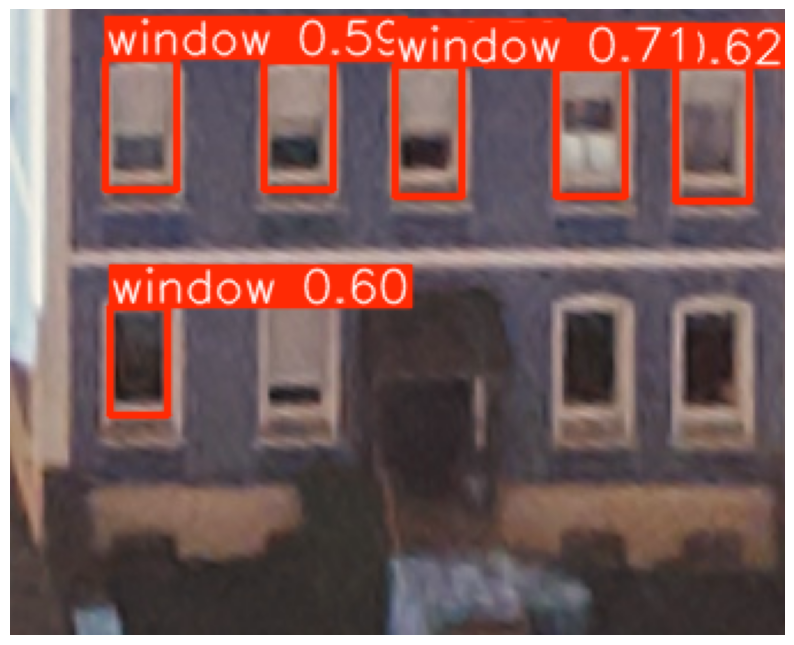

In [12]:
# Define the image path
image_path = os.path.join("Evaluation_subset", "rectified_facade_DENW11AL0000h3Gt.jpg")
# image_path = os.path.join("datasets", "train", "images", "00001.jpg")
# image_path = os.path.join("Evaluation_subset", "rectified_facade_DENW11AL0000h3Ho.jpg")

# Run prediction
results = model.predict(source=image_path, conf=0.5, save=False, save_txt=False, show=False)

print("results", results)

# Load and visualize the image with predictions
annotated_image = results[0].plot()  # Plot the results on the image

# Display the image using Matplotlibs
plt.figure(figsize=(10, 10))
plt.imshow(annotated_image)
plt.axis("off")
plt.show()